In [1]:
%load_ext autoreload
%autoreload 2

import sys
import os
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


from pydrake.geometry.optimization import (
    HPolyhedron, Hyperellipsoid, Iris, IrisOptions, VPolytope, IrisMultiContainment
)
# from pydrake.planning.common_robotics_utilities import (
#     Graph,
#     GrowRoadMap,
#     UpdateRoadMapEdges,
#     QueryPath,
#     LazyQueryPath,
#     AddNodeToRoadmap,
#     NNDistanceDirection
# )
from pydrake.trajectories import PiecewisePolynomial

from iris_helpers import sorted_vertices
#from linear_spp import *

In [10]:
corners = np.array([[0,0.1], [2, -1.0], [2.1, 2], [ 1.1, 2.21], [-1., 1.5]])
res = 1000 
x = []
y = []
for idx in range(len(corners)):
    t = np.linspace(0,1, res)
    for ti in t:
        pt = (1-ti)*corners[idx , :] + (ti)*corners[(idx +1)%len(corners), :]
        x.append(pt[0])
        y.append(pt[1])
x = np.array(x)
y = np.array(y)
x_tf = np.tan(x/2)
y_tf = np.tan(y/2)

(-4, 4)

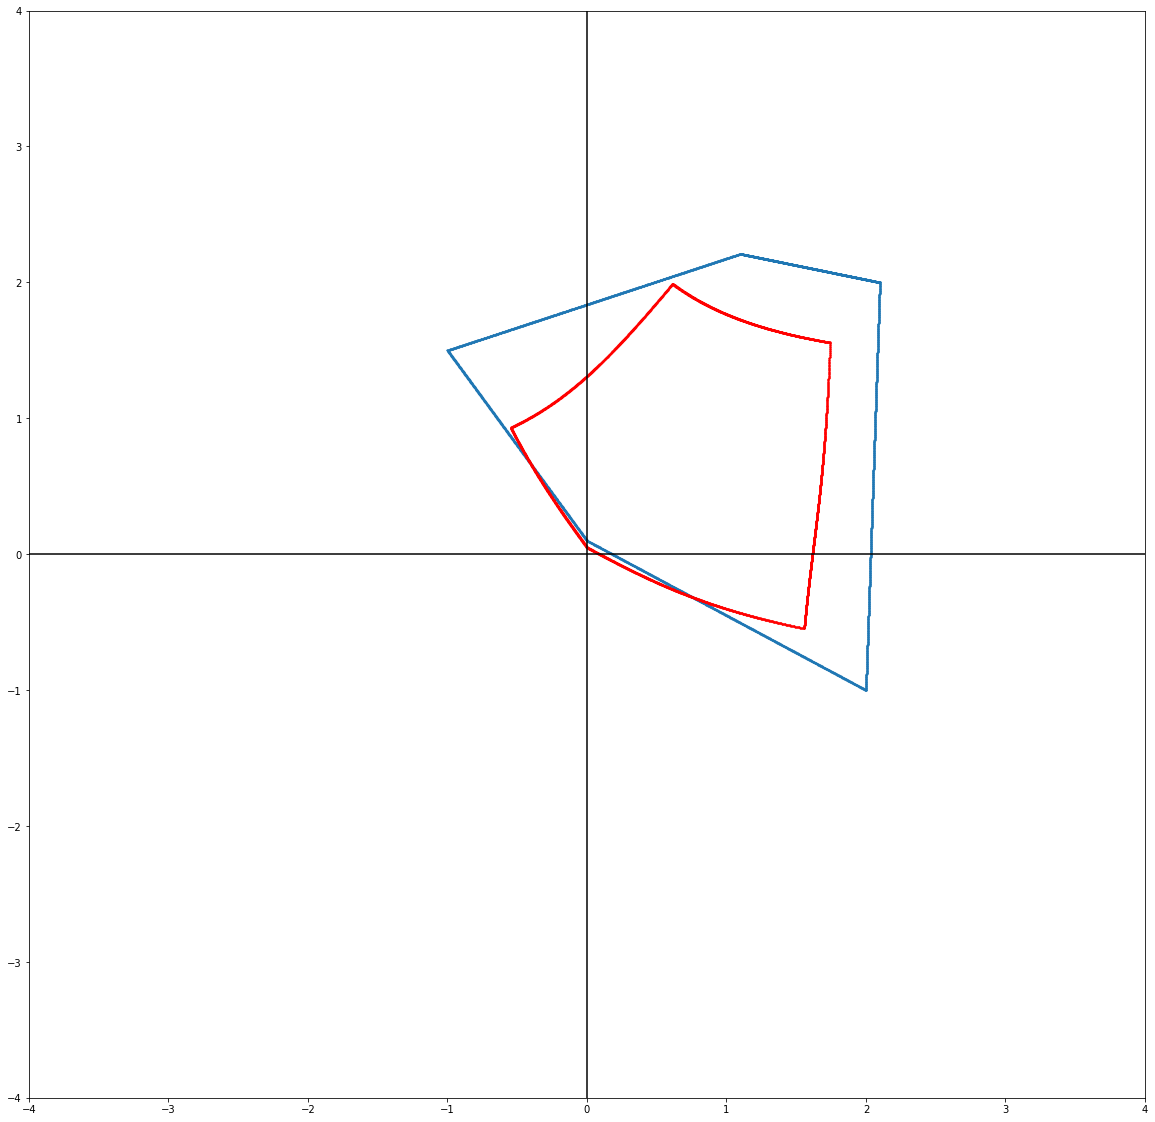

In [11]:
fig, ax = plt.subplots(nrows=1, ncols =1, figsize = (20,20))
ax.scatter(x, y, s =1 )
ax.scatter(x_tf, y_tf, s =1, c= 'r' )
ax.plot([-4,4], [0,0], c = 'k')
ax.plot([0,0], [-4,4], c = 'k')
ax.set_xlim([-4,4])
ax.set_ylim([-4,4])

In [2]:
#save_location = "/home/map/data/random_forest"
save_location = "./random_forest"
if not os.path.exists(save_location):
    os.makedirs(save_location)

# Build Environment

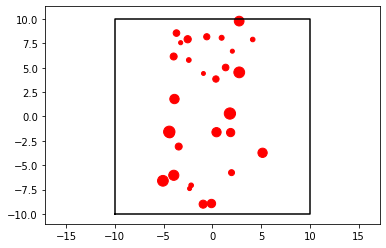

In [12]:
dimension = 2
fill_ratio = 0.05
np.random.seed(1)

lb = np.full((dimension), -10.)
lb[0] = -7
ub = np.full((dimension), 10.)
ub[0] = 7

domain = HPolyhedron.MakeBox([-10.] * dimension, [10.] * dimension)
fill_volume = fill_ratio * (ub[0] - lb[0]) * 20.**(dimension-1.)
obstacles = []
obstacle_volume = 0

lb[0] = -5.5
ub[0] = 5.5
while obstacle_volume < fill_volume:
    center = np.random.rand(dimension) * (ub - lb) + lb
    radius = (np.random.rand(1) + 0.5) * 0.4
    tree = Hyperellipsoid.MakeHypersphere(radius, center)
    obstacle_volume += tree.Volume()
    obstacles.append(tree)
    
if dimension == 2:
    fig, ax = plt.subplots()
    ax.plot([-10, 10, 10, -10, -10], [-10, -10, 10, 10, -10], 'k')
    for o in obstacles:
        tree = plt.Circle(o.center(), 1./o.A()[0, 0], color='r')
        ax.add_patch(tree)
    ax.axis('equal')

In [13]:
def evaluatePlanning(plan_fn, seed, iterations):
    np.random.seed(seed)

    data = []
    
    start_lb = np.full((dimension), -10.)
    start_ub = np.full((dimension), 10.)
    start_ub[0] = -7
    goal_lb = np.full((dimension), -10.)
    goal_ub = np.full((dimension), 10.)
    goal_lb[0] = 7
    
    for ii in range(iterations):
        start = np.random.rand(dimension) * (start_ub - start_lb) + start_lb
        goal = np.random.rand(dimension) * (goal_ub - goal_lb) + goal_lb

#         print("Running iteration", ii, flush=True)
        data_dict = dict()
        data_dict["start"] = start
        data_dict["goal"] = goal
                
        start_plan_time = time.time()
        trajectory = plan_fn(start, goal)
        end_plan_time = time.time()
        
        data_dict["found_path"] = trajectory is not None
        data_dict["plan_time"] = end_plan_time - start_plan_time
        if trajectory is not None:
            path_length = 0
            knots = trajectory.vector_values(trajectory.get_segment_times())
            for ii in range(knots.shape[1] - 1):
                path_length += np.linalg.norm(knots[:, ii+1] - knots[:, ii])
            data_dict["path_length"] = path_length

        data.append(data_dict)

    df = pd.DataFrame(data)
    print(df.mean())

# Generate Iris Regions

Successful seed after 1 guesses: [ 5.42641287 -9.58496101]
Seed: 0 	Time: 0.8151581287384033 	Faces: 7
Successful seed after 2 guesses: [-0.02985975 -5.50406709]
Seed: 1 	Time: 1.2022910118103027 	Faces: 9
Successful seed after 1 guesses: [-6.0387427   5.21061424]
Seed: 2 	Time: 1.8952271938323975 	Faces: 6
Successful seed after 2 guesses: [3.70719637 9.06786692]
Seed: 3 	Time: 1.5250177383422852 	Faces: 7
Successful seed after 2 guesses: [6.25241923 2.25052134]
Seed: 4 	Time: 1.1981189250946045 	Faces: 8
Successful seed after 1 guesses: [ 4.43510635 -4.16247864]
Seed: 5 	Time: 1.1703381538391113 	Faces: 8
Successful seed after 3 guesses: [-2.5331848  3.4826723]
Seed: 6 	Time: 1.9671473503112793 	Faces: 7
Successful seed after 9 guesses: [0.95172312 6.38573991]
Seed: 7 	Time: 1.174015998840332 	Faces: 10
Successful seed after 2 guesses: [-2.96694721  5.09295383]
Seed: 8 	Time: 1.5386312007904053 	Faces: 7
Successful seed after 1 guesses: [-4.08076586  7.67872959]
Seed: 9 	Time: 1.89945

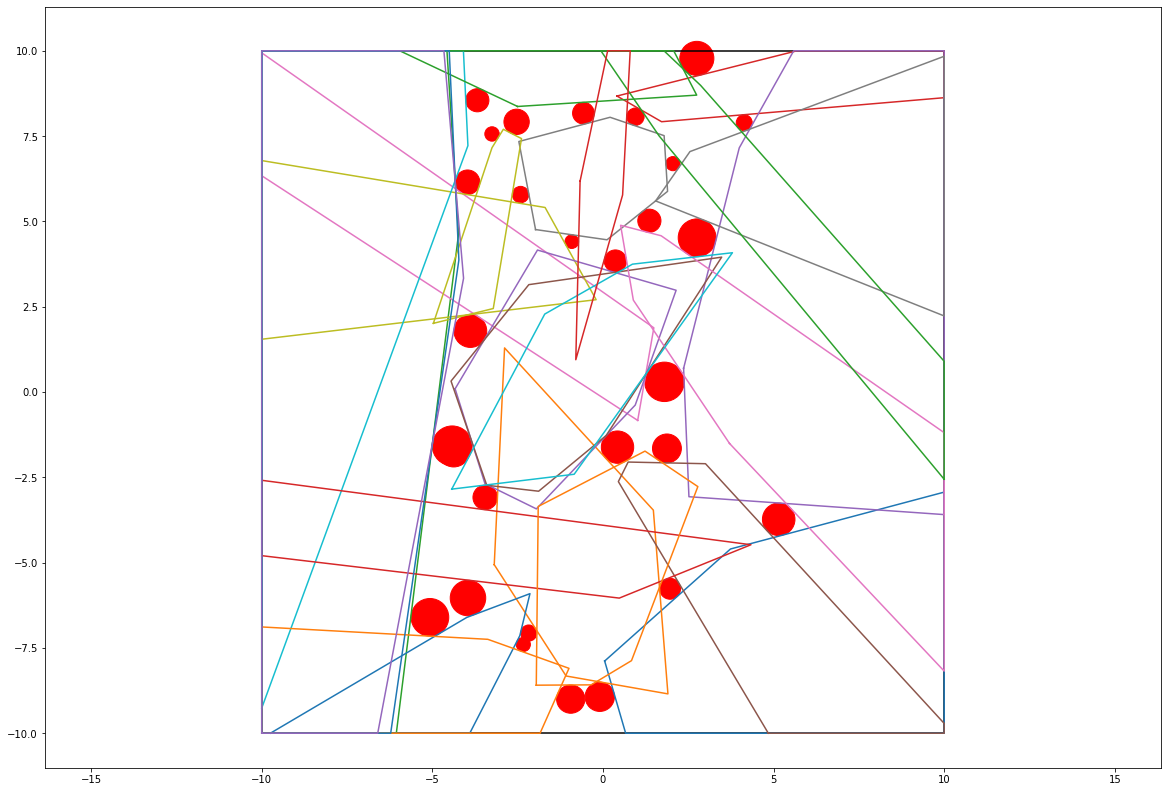

In [68]:
np.random.seed(10)
iris_options = IrisOptions()
iris_options.require_sample_point_is_contained = True
iris_options.iteration_limit = 5
iris_options.termination_threshold = -1
iris_options.relative_termination_threshold = 0.05

setup_time = time.time()
regions = []

# # From Seed Points
# for ii in range(seed_points.shape[0]):
#     start_time = time.time()
#     hpoly = Iris(obstacles, seed_points[ii], domain, iris_options)
#     print("Seed:", ii, "\tTime:", time.time() - start_time, "\tFaces:", hpoly.b().shape[0], flush=True)
#     regions.append(hpoly)

# From random samples
num_regions = len(regions)
num_guesses = 0
lb = np.full((dimension), -10.)
ub = np.full((dimension), 10.)
while num_guesses < 10*(10**dimension) and len(regions) < 5**dimension:
    num_guesses += 1
    seed = np.random.rand(dimension) * (ub - lb) + lb
    in_regions = False
    for R in regions:
        if R.PointInSet(seed):
            in_regions = True
            break
    if in_regions:
        continue
    in_collision = False
    for o in obstacles:
        if o.PointInSet(seed):
            in_collision = True
            break
    if in_collision:
        continue
        
    print("Successful seed after", num_guesses, "guesses:", seed, flush=True)
    
    start_time = time.time()
    try:
        hpoly = Iris(obstacles, seed, domain, iris_options)
    except:
        print(seed)
        continue
    num_guesses = 0
    print("Seed:", len(regions), "\tTime:", time.time() - start_time, "\tFaces:", hpoly.b().shape[0], flush=True)
    regions.append(hpoly)
    
print(f"Time: {time.time() - setup_time}s")

# for ii in range(len(regions)):
#     file_name = save_location + "/region_" + str(ii) + ".npy"
#     with open(file_name, 'wb') as f:
#         np.save(f, regions[ii].A())
#         np.save(f, regions[ii].b())
if dimension == 2:
    fig, ax = plt.subplots(figsize=(20, 14))
    ax.plot([-10, 10, 10, -10, -10], [-10, -10, 10, 10, -10], 'k')
    for o in obstacles:
        tree = plt.Circle(o.center(), 1./o.A()[0, 0], color='r')
        ax.add_patch(tree)
    ax.axis('equal')
    for r in regions:
        vert = sorted_vertices(VPolytope(r))
        vert = np.hstack((vert, vert[:, :1]))
        ax.plot(vert[0], vert[1])

In [69]:
# VISPRM building
import visprm
from functools import partial
from pydrake.all import le, MathematicalProgram, Solve, ge

loc_obs = [o.center().reshape(2,1) for o in obstacles]
radii_obs = [1/o.A()[0,0] for o in obstacles]

def is_LOS(q_src, q_targ, eps = 0.2, dist_thresh = 9.0):
    if np.linalg.norm(q_src-q_targ) > dist_thresh:
        return False, None, None, None
    for idx, (loc, radius) in enumerate(zip(loc_obs, radii_obs)):
        prog = MathematicalProgram()
        t = prog.NewContinuousVariables(1, 't')
        prog.AddBoundingBoxConstraint(0, 1, t)
        a = loc - t*q_src - (1-t)*q_targ
        prog.AddConstraint(le(a.T@a, radius**2 + eps ))
        sol = Solve(prog)
        if sol.is_success():
            return False, sol.GetSolution(t), loc, radius
    return True, sol , loc, radius

def col_handle(q, eps = 0.2):
    dim = q.shape[0]
    for obs in obstacles:
        for idx in range(10*dim):
            p = q + eps*(np.random.rand(dim)-0.5)
            if obs.PointInSet(p):
                return True
    return False

def plot_node(q, is_guard, ax):
    if is_guard:
        ax.scatter(q[0],q[1], c = 'g',s = 100 )
    else:
        ax.scatter(q[0],q[1], c = 'k',s = 20 )

def plot_edge(q1, q2, ax, dashed = False):
    if dashed:
        ax.plot([q1[0], q2[0]], [q1[1], q2[1]], c = 'c', linestyle = '--')
    else:
        ax.plot([q1[0], q2[0]], [q1[1], q2[1]], c = 'k')


guard found, ntry = 0
guard found, ntry = 0
guard found, ntry = 0
guard found, ntry = 1
connector found, ntry = 0
connector found, ntry = 1
connector found, ntry = 4
connector found, ntry = 9
guard found, ntry = 18
guard found, ntry = 8
guard found, ntry = 9
connector found, ntry = 3
guard found, ntry = 23
guard found, ntry = 11
connector found, ntry = 6
connector found, ntry = 22


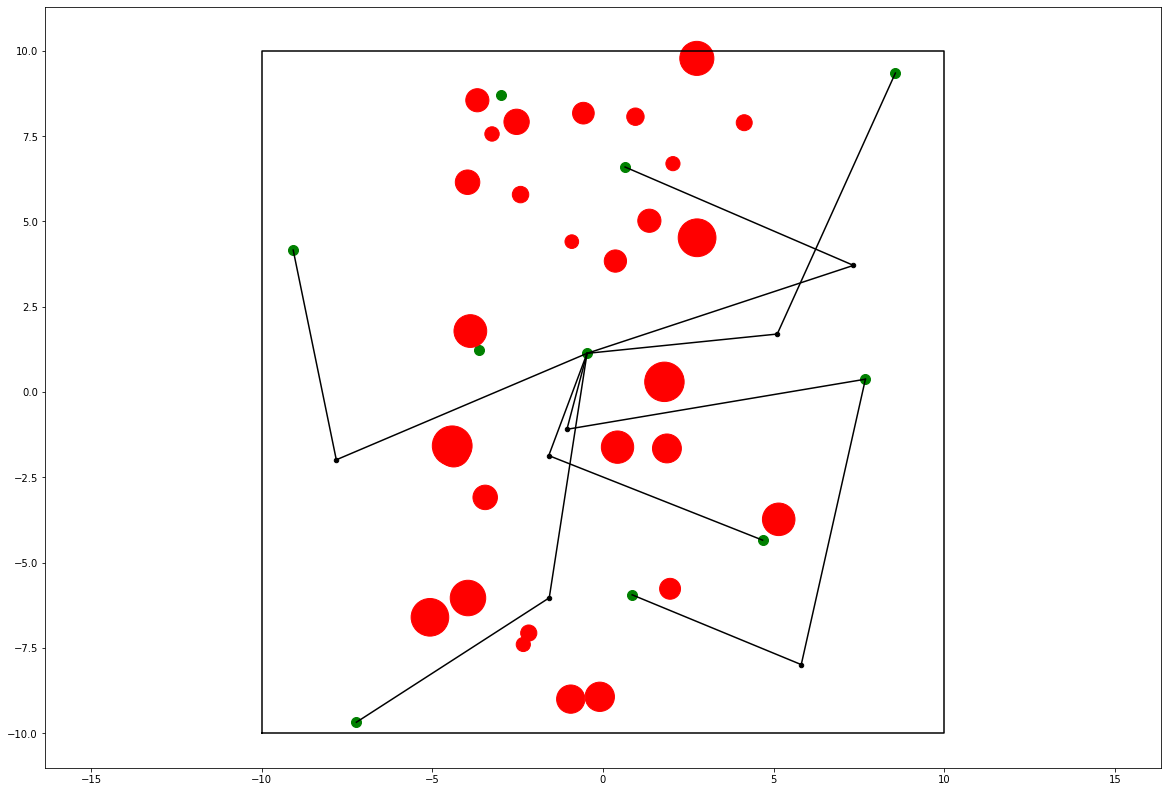

In [70]:
fig, ax = plt.subplots(figsize=(20, 14))
ax.plot([-10, 10, 10, -10, -10], [-10, -10, 10, 10, -10], 'k')
for o in obstacles:
    tree = plt.Circle(o.center(), 1./o.A()[0, 0], color='r')
    ax.add_patch(tree)
ax.axis('equal')

vprm = visprm.VPRM(limits = [lb, ub], 
                    M = 40, 
                    collision_handle = col_handle,
                    is_in_line_of_sight = is_LOS,
                    plot_node = partial(plot_node, ax = ax),
                    plot_edge = partial(plot_edge, ax = ax),
                    Verbose = True)
vprm.build()

In [8]:
#checking coverage
n_vis_samples = 5000
def sample_node_pos(dim, limits, col_handle, MAXIT = 1e4):
        min_pos = limits[0]
        max_pos = limits[1]
        min_max_diff = max_pos - min_pos 
        rand = np.random.rand(dim)
        pos_samp = min_pos + rand*min_max_diff 
        good_sample = not col_handle(pos_samp)

        it = 0
        while not good_sample and it < MAXIT:
            rand = np.random.rand(dim)
            pos_samp = min_pos + rand*min_max_diff 
            good_sample = not col_handle(pos_samp)
            it+=1

        if not good_sample:
            raise ValueError("[VPRM ERROR] Could not find collision free point in MAXIT")
        return pos_samp
    
samples = [sample_node_pos(2, [lb, ub], col_handle, MAXIT = 1e4) for _ in range(n_vis_samples)]

def in_vis_region(q, is_LOS, guard_domains):
    for dom in [guard_domains[0]]:
        for guard in dom:
            if is_LOS(q.reshape(2,1), guard.position.reshape(2,1))[0]:
                return 1
    return 0

n_vis = 0
for idx, s in enumerate(samples):
    if idx%100 ==0:
        print(idx)
    n_vis += in_vis_region(s, is_LOS, vprm.guard_domains)
    
print('empirical coverage', n_vis/n_vis_samples)
print('estimated coverage', 1- 1.0/vprm.M)

0
100
200
300
400
500
600
700
800
900


KeyboardInterrupt: 

In [71]:
ptcheck = np.array([-3.2, 7.9]).reshape(2,1)
print(in_vis_region(ptcheck, is_LOS, vprm.guard_domains))

fig, ax = plt.subplots(figsize=(20, 14))
ax.plot([-10, 10, 10, -10, -10], [-10, -10, 10, 10, -10], 'k')
for o in obstacles:
    tree = plt.Circle(o.center(), 1./o.A()[0, 0], color='r')
    ax.add_patch(tree)
tree = plt.Circle(ptcheck, 0.1, color='b')
ax.add_patch(tree)

for g in vprm.guards:
    plot_node(g.position, is_guard = True, ax = ax)
for c in vprm.connectors:
    plot_node(c.position, is_guard = False, ax = ax)
    for vis in c.connections:
        plot_edge(c.position, vis.position, ax= ax)
ax.axis('equal')

NameError: name 'in_vis_region' is not defined

In [10]:
def switch_ellipse_description(A, b):
    d = np.linalg.solve(A.T@A, -A.T@b)
    return Hyperellipsoid(A,d), A, d

def get_seed_ellipse(pt1, pt2, eps = 0.01):
    dim = pt1.shape[0]
    pts = [pt1, pt2]
    for _ in range(2*dim):
        m = 0.5*(pt1+pt2) + eps*(np.random.rand(2,1)-0.5)
        pts.append(m)

    prog = MathematicalProgram()
    A = prog.NewSymmetricContinuousVariables(dim, 'A')
    b = prog.NewContinuousVariables(dim, 'b')
    prog.AddMaximizeLogDeterminantCost(A)
    for idx, pt in enumerate(pts):
        S = prog.NewSymmetricContinuousVariables(dim+1, 'S')
        prog.AddPositiveSemidefiniteConstraint(S)
        prog.AddLinearEqualityConstraint(S[0,0] == 1)
        v = (A@pt + b.reshape(2,1)).T
        c = (S[1:,1:]-np.eye(dim)).reshape(-1)
        for idx in range(dim):
            prog.AddLinearEqualityConstraint(S[0,1 + idx]-v[0,idx], 0 )
        for ci in c:
            prog.AddLinearEqualityConstraint(ci, 0 )

    prog.AddPositiveSemidefiniteConstraint(A)

    sol = Solve(prog)
    if sol.is_success():
        return switch_ellipse_description(sol.GetSolution(A), sol.GetSolution(b))
    else:
        return None, None, None
         
def plot_ellipse(ax, A, center, n_samples):
    angs = np.linspace(0, 2*np.pi, n_samples+1)
    coords = np.zeros((2, n_samples + 1))
    coords[0, :] = np.cos(angs)
    coords[1, :] = np.sin(angs)
    Bu = np.linalg.inv(A)@coords
    pts = Bu + center.reshape(2,1)
    ax.plot(pts[0, :], pts[1, :], linewidth = 1)

In [11]:
pt1 = np.array([0,0]).reshape(2,1)
pt2 = np.array([1,2]).reshape(2,1)
pts = np.vstack([pt1.T, pt2.T])

#init_ellipse, A, center = get_seed_ellipse(pt1, pt2, 0.3)

iris_options = IrisOptions()
iris_options.require_sample_point_is_contained = True
iris_options.iteration_limit = 5
iris_options.termination_threshold = -1
iris_options.relative_termination_threshold = 0.0005

#Reg = IrisMultiContainment(obstacles, pts, init_ellipse, domain, iris_options)


In [12]:
#build iris regions around visprm
guard_regions = []
for guard in vprm.guard_domains[0]:
    seed = guard.position.reshape(2,1)
    guard_regions.append(Iris(obstacles, seed, domain, iris_options))

connector_regions = []
seed_ellipses = []
for connector in vprm.connectors:
    for c in connector.connections:
        pt1 = connector.position.reshape(2,1)
        pt2 = c.position.reshape(2,1)
        ell_seed, a, c = get_seed_ellipse(pt1, pt2, eps = 0.2)
        seed_ellipses.append(ell_seed)
        pts = np.vstack([pt1.T, pt2.T])
        connector_regions.append(IrisMultiContainment(obstacles, pts, ell_seed, domain, iris_options))
        

(-11.000000000000002, 11.0, -11.013824401994093, 11.290312441875923)

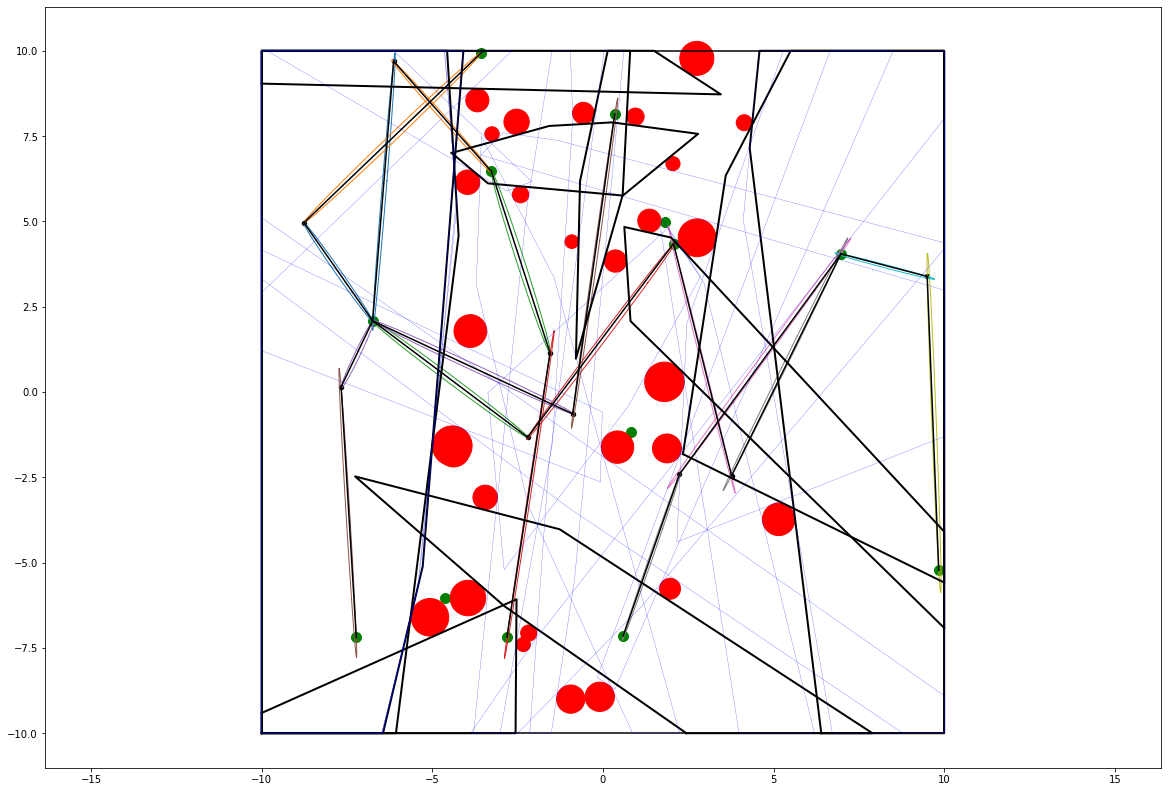

In [13]:
from matplotlib.patches import Ellipse
fig, ax = plt.subplots(figsize=(20, 14))
ax.plot([-10, 10, 10, -10, -10], [-10, -10, 10, 10, -10], 'k')
for e in seed_ellipses:
    plot_ellipse(ax, e.A(), e.center(), 50)

for o in obstacles:
    tree = plt.Circle(o.center(), 1./o.A()[0, 0], color='r')
    ax.add_patch(tree)
for r in guard_regions:
    vert = sorted_vertices(VPolytope(r))
    vert = np.hstack((vert, vert[:, :1]))
    ax.plot(vert[0], vert[1], c = 'k', linewidth = 2)
for r in connector_regions:
    vert = sorted_vertices(VPolytope(r))
    vert = np.hstack((vert, vert[:, :1]))
    ax.plot(vert[0], vert[1], c = 'b', linewidth = 0.2)

for g in vprm.guards:
    plot_node(g.position, is_guard = True, ax = ax)
for c in vprm.connectors:
    plot_node(c.position, is_guard = False, ax = ax)
    for vis in c.connections:
        plot_edge(c.position, vis.position, ax= ax)
ax.axis('equal')


True
True
True
True
True
True
True
True
True
True


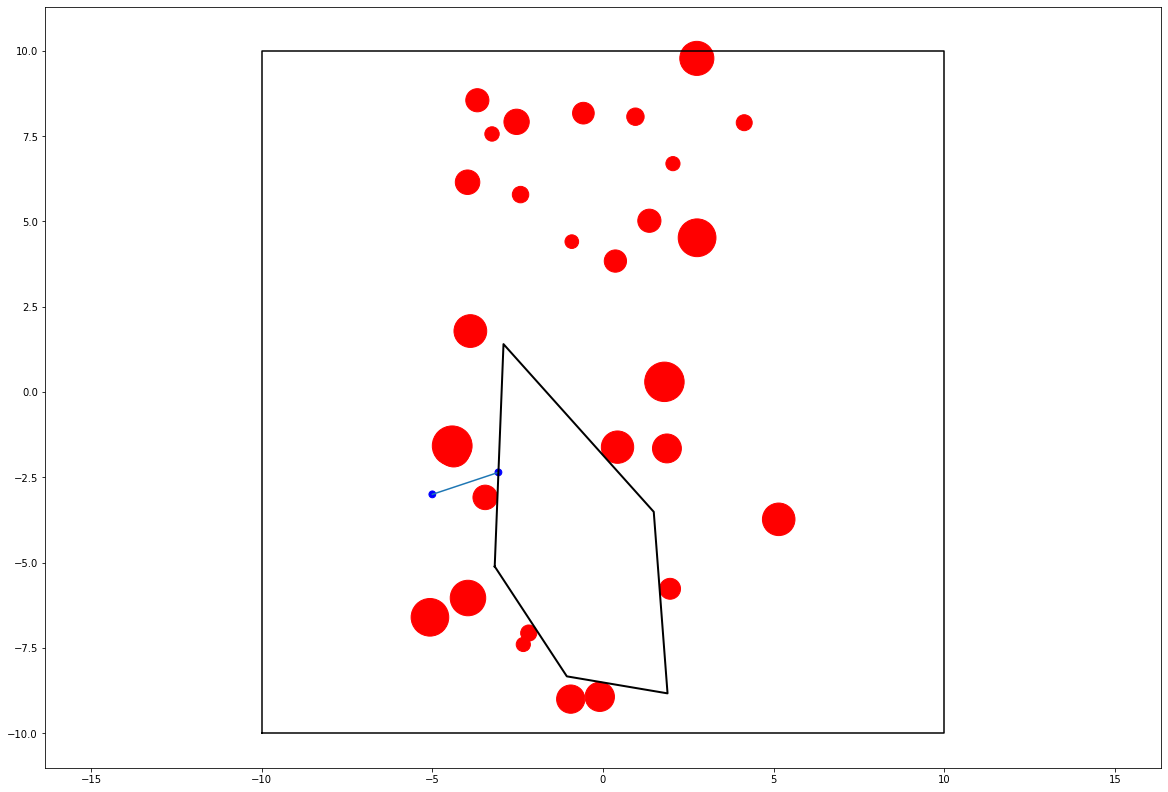

In [14]:
#set visibility program
#Muller , Marsaglia (‘Normalised Gaussians’) approach
def sample_unit_ball(dim):
    u = np.random.normal(0,1,dim).reshape(2,1)  
    val = np.linalg.norm(u)
    return u/val

def sample_in_set(ell):
    B = np.linalg.inv(ell.A())
    center = ell.center().reshape(2,1)
    return B@sample_unit_ball(center.shape[0]) + center

n_tries = 10
margin = 0.2
src_reg = guard_regions[3]
src_ell = src_reg.MaximumVolumeInscribedEllipsoid()
src_pt = np.array([-5,-3.0]).reshape(2,1)
loc_obs = [o.center().reshape(2,1) for o in obstacles]
radii_obs = [1/o.A()[0,0] for o in obstacles]

dim = src_pt.shape[0] 
one_success = False
costs = []
pi_sols = []

for _ in range(n_tries):
    prog = MathematicalProgram()
    p_i = prog.NewContinuousVariables(dim, 'p_i')
    prog.AddCost(((p_i.reshape(2,1) - src_pt).T@(p_i.reshape(2,1) - src_pt))[0,0])
    prog.AddLinearConstraint(src_reg.A(), -np.inf + 0*src_reg.b(), src_reg.b(), p_i)
    t_vals = np.linspace(0, 1, 21)
    for t in t_vals[:-1]:
        for loc, rad in zip(loc_obs, radii_obs):
            checkpt = t*src_pt + (1-t)*p_i.reshape(2,1) - loc
            prog.AddConstraint(ge((checkpt.T@checkpt) - rad**2 - margin, 0))

    prog.SetInitialGuess(p_i, sample_in_set(src_ell))
    sol = Solve(prog)
    print(sol.is_success())
    if sol.is_success:
        one_success = True
        costs.append(sol.get_optimal_cost())
        pi_sols.append(sol.GetSolution(p_i).reshape(2,1))

if one_success:
    c = np.array(costs)
    idx = np.argsort(c)
    
    p_in_set = pi_sols[idx[0]]


    fig, ax = plt.subplots(figsize=(20, 14))
    ax.plot([-10, 10, 10, -10, -10], [-10, -10, 10, 10, -10], 'k')

    tree = plt.Circle(src_pt, 0.1, color='b')
    ax.add_patch(tree)
    
    tree = plt.Circle(p_in_set, 0.1, color='b')
    ax.add_patch(tree)
    ax.plot([src_pt[0,0], p_in_set[0,0]], [src_pt[1,0], p_in_set[1,0]])
    for o in obstacles:
        tree = plt.Circle(o.center(), 1./o.A()[0, 0], color='r')
        ax.add_patch(tree)
    ax.axis('equal')
    for r in [src_reg]:
        vert = sorted_vertices(VPolytope(r))
        vert = np.hstack((vert, vert[:, :1]))
        ax.plot(vert[0], vert[1], c = 'k', linewidth = 2)
    


In [72]:
domain = HPolyhedron.MakeBox([-10.] * dimension, [10.] * dimension)

iris_options = IrisOptions()
iris_options.require_sample_point_is_contained = True
iris_options.iteration_limit = 5
iris_options.termination_threshold = -1
iris_options.relative_termination_threshold = 0.05

def morph_iris(pt, obstacles, domain, options):
    return Iris(obstacles, pt, domain, iris_options)

def sample_unit_ball(dim):
    u = np.random.normal(0,1,dim).reshape(2,1)  
    val = np.linalg.norm(u)
    return u/val

def sample_in_set(ell):
    B = np.linalg.inv(ell.A())
    center = ell.center().reshape(2,1)
    return B@sample_unit_ball(center.shape[0]) + center

def set_LOS_check(q,
                  region,
                  obstacles,
                  sample_in_set,
                  margin = 0.2,
                  n_tries = 10,
                  ncollisionchecks = 11,
                  maxdist = 5):
    dim = q.shape[0] 
    if region.PointInSet(q):
        return True, q
    prog = MathematicalProgram()
    p_i = prog.NewContinuousVariables(dim, 'p_i')
    prog.AddCost(((p_i.reshape(2,1) - q).T@(p_i.reshape(2,1) - q))[0,0])
    prog.AddLinearConstraint(region.A(), -np.inf + 0*region.b(), region.b(), p_i)
    sol = Solve(prog)
    if sol.is_success():
        if np.sqrt(sol.get_optimal_cost() + 1e-9)>maxdist:
            return False, None
    
    loc_obs = [o.center().reshape(2,1) for o in obstacles]
    radii_obs = [1/o.A()[0,0] for o in obstacles]
    
    inscribed_ellipse = region.MaximumVolumeInscribedEllipsoid()
    
    one_success = False
    costs = []
    pi_sols = []
    
    t_vals = np.linspace(0, 1, ncollisionchecks)
    for _ in range(n_tries):
        prog = MathematicalProgram()
        p_i = prog.NewContinuousVariables(dim, 'p_i')
        prog.AddCost(((p_i.reshape(2,1) - q).T@(p_i.reshape(2,1) - q))[0,0])
        prog.AddLinearConstraint(region.A(), -np.inf + 0*region.b(), region.b(), p_i)
        for t in t_vals[:-1]:
            for loc, rad in zip(loc_obs, radii_obs):
                checkpt = t*q + (1-t)*p_i.reshape(2,1) - loc
                prog.AddConstraint(ge((checkpt.T@checkpt) - rad**2 - margin, 0))

        prog.SetInitialGuess(p_i, sample_in_set(inscribed_ellipse))
        sol = Solve(prog)
        #print('dist', )
        if sol.is_success() and np.linalg.norm(sol.GetSolution(p_i)-q)< maxdist:
            one_success = True
            costs.append(sol.get_optimal_cost())
            pi_sols.append(sol.GetSolution(p_i).reshape(2,1))
            break
            
    if one_success:
        c = np.array(costs)
        idx = np.argsort(c) 
        p_in_set = pi_sols[idx[0]]
        return True, p_in_set
    else:
        return False, None
    
def plot_node(q, is_guard, ax):
    if is_guard:
        ax.scatter(q[0],q[1], c = 'g',s = 100 )
    else:
        ax.scatter(q[0],q[1], c = 'k',s = 20 )

def plot_edge(q1, q2, ax):
    ax.plot([q1[0], q2[0]], [q1[1], q2[1]], c = 'k')

def plot_region(reg, ax):
    vert = sorted_vertices(VPolytope(reg))
    vert = np.hstack((vert, vert[:, :1]))
    ax.plot(vert[0], vert[1], c = 'k', linewidth = 2)

guard found, ntry = 0
guard found, ntry = 0
guard found, ntry = 2
guard found, ntry = 3
connector found, ntry = 0
connector found, ntry = 2
connector found, ntry = 6
guard found, ntry = 15
connector found, ntry = 1
guard found, ntry = 17
connector found, ntry = 3
building connector regions


/home/peter/.local/lib/python3.8/site-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


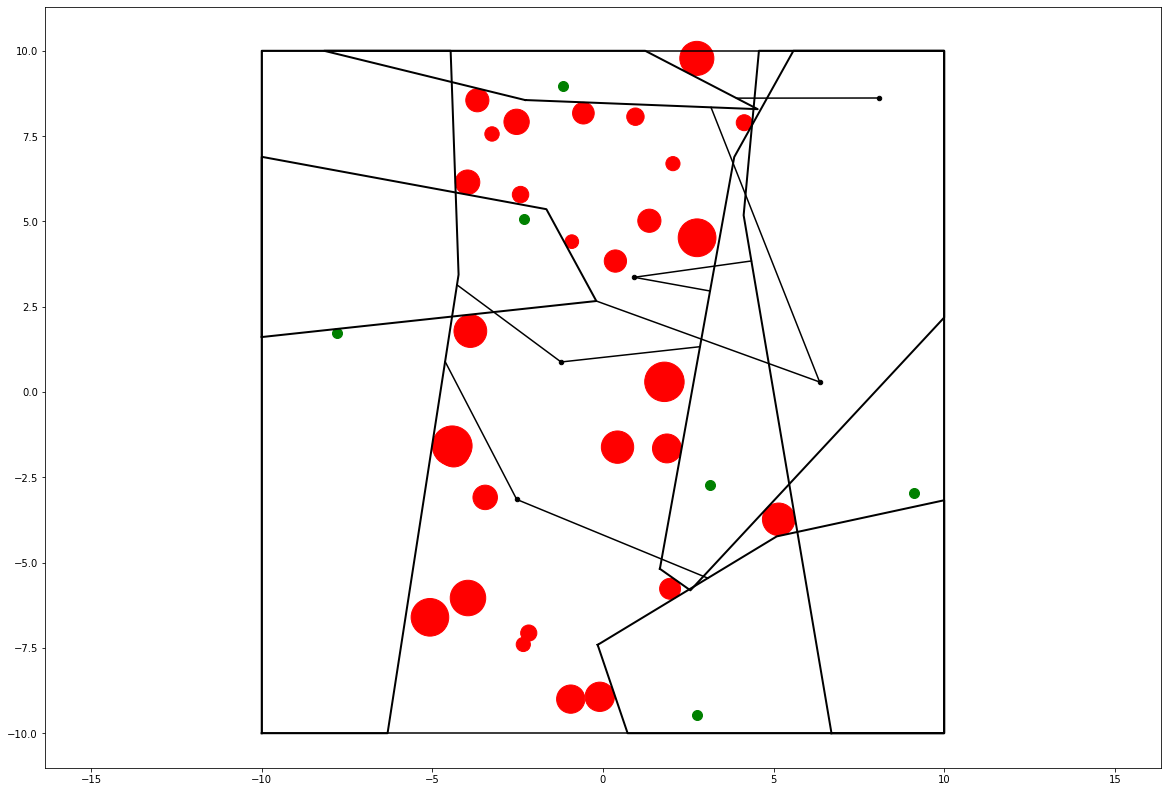

In [16]:
np.random.seed(3)
iris_handle = partial(morph_iris, 
                      obstacles = obstacles, 
                      domain = domain, 
                      options = iris_options)   

set_LOS_check_handle = partial(set_LOS_check, 
                            obstacles = obstacles, 
                            sample_in_set = sample_in_set,
                            margin = 0.5,
                            n_tries = 10,
                            ncollisionchecks = 11, 
                            maxdist = 10.0)

fig, ax = plt.subplots(figsize=(20, 14))
ax.plot([-10, 10, 10, -10, -10], [-10, -10, 10, 10, -10], 'k')
for o in obstacles:
    tree = plt.Circle(o.center(), 1./o.A()[0, 0], color='r')
    ax.add_patch(tree)
ax.axis('equal')

setvprm = visprm.SetVPRM(limits = [lb, ub], 
                    M = 20, 
                    collision_handle = col_handle,
                    is_in_line_of_sight = set_LOS_check_handle,
                    iris_handle = iris_handle,
                    connector_iris_handle = None,
                    plot_node = partial(plot_node, ax = ax),
                    plot_edge = partial(plot_edge, ax = ax),
                    plot_region = partial(plot_region, ax = ax),
                    Verbose = True)

setvprm.build()
#src_pt = np.array([-5, 7.5]).reshape(2,1)
#tree = plt.Circle(src_pt, 0.1, color='b')
#ax.add_patch(tree)
#is_los, pt_in_set = set_LOS_check_handle(src_pt, setvprm.guard_regions[0])

#tree = plt.Circle(pt_in_set, 0.1, color='g')
#ax.add_patch(tree)
#ax.plot([src_pt[0,0], pt_in_set[0,0]], [src_pt[1,0], pt_in_set[1,0]])

In [17]:
pt = setvprm.guard_regions[0].MaximumVolumeInscribedEllipsoid().center()
r = setvprm.guard_regions[0]
set_LOS_check_handle = partial(set_LOS_check, 
                            obstacles = obstacles, 
                            sample_in_set = sample_in_set,
                            margin = 0.5,
                            n_tries = 10,
                            ncollisionchecks = 11, 
                            maxdist = 10.0)

a,s = set_LOS_check_handle(pt,r)

In [18]:
setvprm.guards[0].region.IntersectsWith(setvprm.guards[1].region)

True

True
True
True
True
True
True
True
True
True
True
True
0


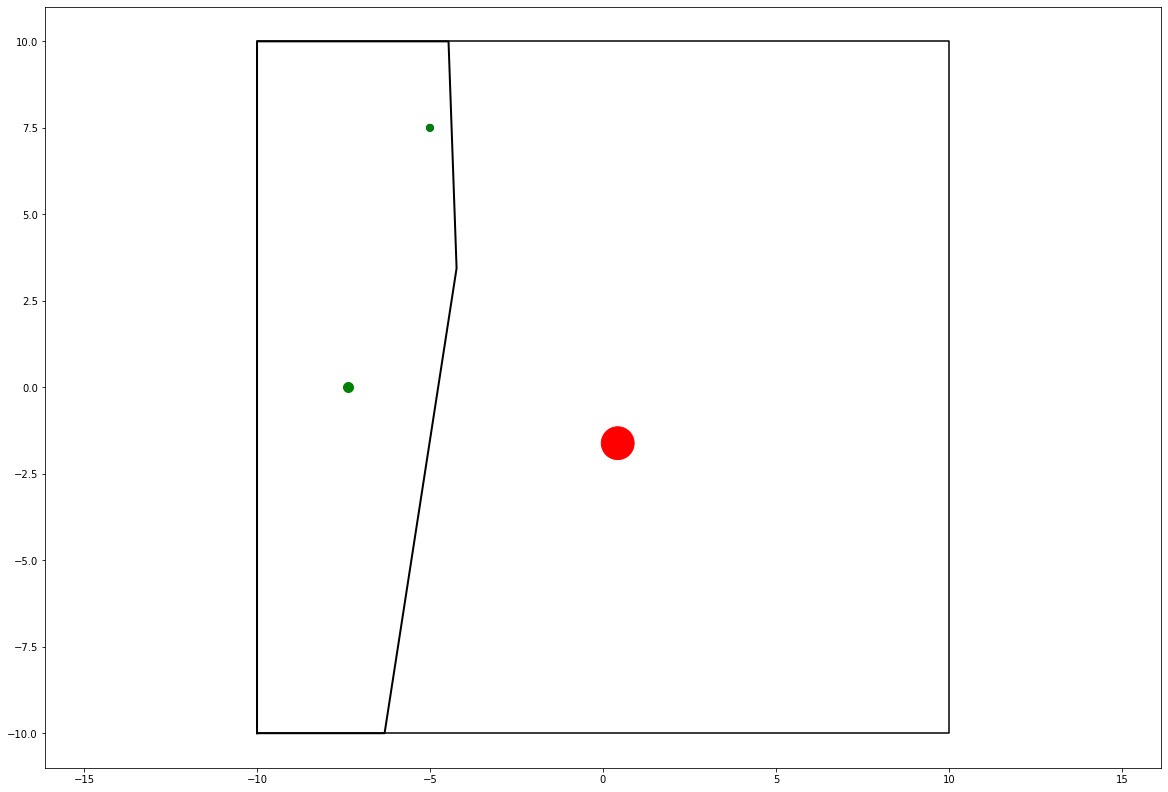

In [19]:
np.random.seed(30)
reg =  setvprm.guard_regions[0]
src_pt = np.array([-5, 7.5]).reshape(2,1)

fig, ax = plt.subplots(figsize=(20, 14))
ax.plot([-10, 10, 10, -10, -10], [-10, -10, 10, 10, -10], 'k')
for o in [obstacles[3]]:
    tree = plt.Circle(o.center(), 1./o.A()[0, 0], color='r')
    ax.add_patch(tree)
plot_node(setvprm.guards[0].position, 'guard', ax)
ax.axis('equal')
plot_region(reg, ax)
tree = plt.Circle(src_pt, 0.1, color='b')
ax.add_patch(tree)
#is_los, pt_in_set = set_LOS_check(src_pt, reg, obstacles, sample_in_set, margin = 0.2, ntries = 10, ncollisionchecks = 11)

margin = 1.0
ncollisionchecks = 10
n_tries = 10

loc_obs = [o.center().reshape(2,1) for o in obstacles]
radii_obs = [1/o.A()[0,0] for o in obstacles]
dim = src_pt.shape[0] 

inscribed_ellipse = reg.MaximumVolumeInscribedEllipsoid()

one_success = False
costs = []
pi_sols = []

t_vals = np.linspace(0, 1, ncollisionchecks)
for _ in range(n_tries):
    prog = MathematicalProgram()
    p_i = prog.NewContinuousVariables(dim, 'p_i')
    prog.AddCost(((p_i.reshape(2,1) - src_pt).T@(p_i.reshape(2,1) - src_pt))[0,0])
    prog.AddLinearConstraint(reg.A(), -np.inf + 0*reg.b(), reg.b(), p_i)
    for t in t_vals[:-1]:
        for loc, rad in zip(loc_obs, radii_obs):
            checkpt = t*src_pt + (1-t)*p_i.reshape(2,1) - loc
            prog.AddConstraint(ge(10*((checkpt.T@checkpt) - rad**2 - margin), 0))

    prog.SetInitialGuess(p_i, sample_in_set(inscribed_ellipse))
    sol = Solve(prog)
    print(sol.is_success())
    if sol.is_success():
        one_success = True
        costs.append(sol.get_optimal_cost())
        pi_sols.append(sol.GetSolution(p_i).reshape(2,1))

if one_success:
    print(one_success)
    c = np.array(costs)
    idx = np.argsort(c) 
    pt_in_set = pi_sols[idx[0]]
    violations = 0
    for t in t_vals[:-1]:
        for loc, rad in zip(loc_obs, radii_obs):
            checkpt = t*src_pt + (1-t)*pt_in_set.reshape(2,1) - loc
            if (checkpt.T@checkpt) - rad**2 - margin < 0:
                violations +=1
                print((checkpt.T@checkpt) - rad**2 - margin)
    print(violations)


ax.plot([src_pt[0,0], pt_in_set[0,0]], [src_pt[1,0], pt_in_set[1,0]])
tree = plt.Circle(pt_in_set, 0.1, color='g')
ax.add_patch(tree)


In [73]:
class SetNode:
    def __init__(self, position, region, nodetype = '', connections = []):
        self.type = nodetype
        self.region = region
        self.position = position
        self.connections = connections  

#Muller , Marsaglia (‘Normalised Gaussians’) approach to sampling surface of L2-ball
def sample_unit_ball(dim):
    u = np.random.normal(0,1,dim).reshape(2,1)  
    val = np.linalg.norm(u)
    return u/val

#warp sampling - clean up later
def sample_in_set(ell):
    B = np.linalg.inv(ell.A())
    center = ell.center().reshape(2,1)
    return B@sample_unit_ball(center.shape[0]) + center

class EllipseSampler:
    def __init__(self, ell):
        self.eigs, self.eigv = np.linalg.eig(ell.A().T@ell.A())
        self.center = ell.center()
    def sample(self,):
        u = np.random.normal(0,1,dim, ).reshape(2,1)
        
        
class SetVPRM2:
    def __init__(self,
                 limits = None,
                 M = 10,
                 collision_handle = None,
                 is_in_line_of_sight = None,
                 iris_handle = None,
                 connector_iris_handle = None,
                 plot_node = None,
                 plot_edge = None,
                 plot_region = None,
                 Verbose = False):
        
        self.M = M
        self.los_handle = is_in_line_of_sight
        self.col_handle = collision_handle
        self.iris_handle = iris_handle
        self.connector_iris_handle = connector_iris_handle
        self.plot_node = plot_node
        self.plot_edge = plot_edge
        self.plot_region = plot_region
        self.limits = limits
        self.min_pos = self.limits[0]
        self.max_pos = self.limits[1]
        self.min_max_diff = self.max_pos - self.min_pos 
        self.dim = len(self.min_pos)
        self.Verbose = Verbose
        
        self.guard_domains = []
        self.guards = []
        self.connectors = []
        #self.guard_regions = []
        self.guard_seeds = []
        self.connector_regions = []

    def make_guard(self, q):
        region = self.iris_handle(q)
        ellipse = region.MaximumVolumeInscribedEllipsoid()
        new_guard = SetNode(ellipse.center(), region, 'guard', connections = [])
        self.guards.append(new_guard)
        #self.guard_regions.append(region)
        
        is_new_domain = True
        doms_connected = []
        guard_regions_intersected = []
        for dom in self.guard_domains:
            for node in dom:
                if region.IntersectsWith(node.region):
                    doms_connected.append(dom)
                    guard_regions_intersected.append(node)
                    #new_guard.connections.append(node)
                    #node.connections.append(self.guards[-1])
                    is_new_domain = False
        if is_new_domain:
            self.guard_domains.append([self.guards[-1]])
        else:    
            #add connections
            for g_other in guard_regions_intersected:
                new_guard.connections.append(g_other)
                #g_other.connections.append(new_guard)
            #merge domains
            dom_idxs = [self.guard_domains.index(d) for d in doms_connected]
            self.guard_domains[dom_idxs[0]].append(new_guard)
            #reduce domains if region intersects more than one
            if len(dom_idxs)>1:
                #reduce merged domain to the first one at idx = dom_idxs[0]
                #print('merge start \n', self.guard_domains)
                #print('to merge \n', doms_connected)
                for idx_dom_oth in dom_idxs[1:]:
                    if idx_dom_oth != dom_idxs[0]:
                        self.guard_domains[dom_idxs[0]] = self.guard_domains[dom_idxs[0]] + self.guard_domains[idx_dom_oth]
                    #print('extending done \n', self.guard_domains)
                #init with merged domain, futher duplicates not added
                gdm = [self.guard_domains[dom_idxs[0]]]
                for idx, dom in enumerate(self.guard_domains):
                    if idx not in dom_idxs[1:]:
                        gdm.append(dom)
                self.guard_domains = gdm
                #print('done \n', self.guard_domains)
                
    def point_in_guard_regions(self, q):
        for g in self.guards:
            r = g.region
            if r.PointInSet(q):
                return True
        return False

    def build(self,):
        ntry = 0
        q = self.sample_node_pos()
            
        while ntry < self.M:
            q = self.sample_node_pos()
            vis_guards = []
            vis_guard_domains = []
            vis_guards_pt_in_set = []
            break_flag = False
            for domain in self.guard_domains:
                #print(self.guard_domains)
                #is_found = False
                #break_flag = False
                for guard in domain:
                    #print(q.reshape(2,1))
                    #print(guard.position.reshape(2,1))
                    is_los, pt_in_set = self.los_handle(q.reshape(2,1), guard.region)
                    #print(is_los)
                    if is_los:
                        #is_found = True
                        if len(vis_guards) == 0:
                            vis_guards.append(guard)
                            vis_guard_domains.append(self.guard_domains.index(domain))
                            vis_guards_pt_in_set.append(pt_in_set)
                        else:
                            #is connector
                            vis_guards.append(guard)
                            vis_guards_pt_in_set.append(pt_in_set)
                            self.connectors.append(SetNode(q, None, 'connector', connections = [vis_guards, vis_guards_pt_in_set]))
                            print('connector found, ntry =', ntry)  if self.Verbose else None 
                            #merge visible domains
                            other_domain = self.guard_domains[vis_guard_domains[0]]
                            cur_domain_idx = self.guard_domains.index(domain)
                            self.guard_domains[vis_guard_domains[0]] = other_domain + domain
                            self.guard_domains = \
                            [dom for idx, dom in enumerate(self.guard_domains) if idx!= cur_domain_idx]
                            break_flag = True
                        break
                if break_flag:
                    break
            if len(vis_guards)==0:
                self.guard_seeds.append(q)
                self.make_guard(q)
                print('guard found, ntry =', ntry) if self.Verbose else None
                ntry = 0 
            else:
                ntry +=1
        print('building connector regions')
        #check if connector point self.guards[-1]in region

        if self.plot_edge is not None:
            self.plot()
        
    def plot(self,):
        for g, s in zip(self.guards, self.guard_seeds):
            self.plot_node(g.position, is_guard = True)
            self.plot_node(s, is_guard = False)
            for con in g.connections:
                self.plot_edge(con.position, g.position, dashed = True)
        for c in self.connectors:
            self.plot_node(c.position, is_guard = False)
            for vis_pt_in_set in c.connections[1]:
                self.plot_edge(c.position, vis_pt_in_set)
        for g in self.guards:
            r = g.region
            self.plot_region(r)

    def sample_node_pos(self, MAXIT = 1e4):  
        rand = np.random.rand(self.dim)
        pos_samp = self.min_pos + rand*self.min_max_diff 
        good_sample = (not self.col_handle(pos_samp)) and (not self.point_in_guard_regions(pos_samp))

        it = 0
        while not good_sample and it < MAXIT:
            rand = np.random.rand(self.dim)
            pos_samp = self.min_pos + rand*self.min_max_diff 
            good_sample = (not self.col_handle(pos_samp)) and (not self.point_in_guard_regions(pos_samp))
            it+=1

        if not good_sample:
            raise ValueError("[VPRM ERROR] Could not find collision free point in MAXIT")
        return pos_samp

In [76]:
domain = HPolyhedron.MakeBox([-10.] * dimension, [10.] * dimension)

iris_options = IrisOptions()
iris_options.require_sample_point_is_contained = True
iris_options.iteration_limit = 5
iris_options.termination_threshold = -1
iris_options.relative_termination_threshold = 0.05

def morph_iris(pt, obstacles, domain, options):
    return Iris(obstacles, pt, domain, iris_options)

def sample_unit_ball(dim):
    u = np.random.normal(0,1,dim).reshape(2,1)  
    val = np.linalg.norm(u)
    return u/val


def sample_in_set(ell):
    B = np.linalg.inv(ell.A())
    center = ell.center().reshape(2,1)
    return B@sample_unit_ball(center.shape[0]) + center

def set_LOS_check(q,
                  region,
                  obstacles,
                  sample_in_set,
                  margin = 0.2,
                  n_tries = 30,
                  ncollisionchecks = 11,
                  maxdist = 5):
    dim = q.shape[0] 
    if region.PointInSet(q):
        return True, q
    prog = MathematicalProgram()
    p_i = prog.NewContinuousVariables(dim, 'p_i')
    prog.AddCost(((p_i.reshape(2,1) - q).T@(p_i.reshape(2,1) - q))[0,0])
    prog.AddLinearConstraint(region.A(), -np.inf + 0*region.b(), region.b(), p_i)
    sol = Solve(prog)
    if sol.is_success():
        if np.sqrt(sol.get_optimal_cost() + 1e-9)>maxdist:
            return False, None
    
    loc_obs = [o.center().reshape(2,1) for o in obstacles]
    radii_obs = [1/o.A()[0,0] for o in obstacles]
    
    inscribed_ellipse = region.MaximumVolumeInscribedEllipsoid()
    
    one_success = False
    costs = []
    pi_sols = []
    
    t_vals = np.linspace(0, 1, ncollisionchecks)
    for _ in range(n_tries):
        prog = MathematicalProgram()
        p_i = prog.NewContinuousVariables(dim, 'p_i')
        prog.AddCost(((p_i.reshape(2,1) - q).T@(p_i.reshape(2,1) - q))[0,0])
        prog.AddLinearConstraint(region.A(), -np.inf + 0*region.b(), region.b(), p_i)
        for t in t_vals[:-1]:
            for loc, rad in zip(loc_obs, radii_obs):
                checkpt = t*q + (1-t)*p_i.reshape(2,1) - loc
                prog.AddConstraint(ge((checkpt.T@checkpt) - rad**2 - margin, 0))

        prog.SetInitialGuess(p_i, sample_in_set(inscribed_ellipse))
        sol = Solve(prog)
        #print('dist', )
        if sol.is_success() and np.linalg.norm(sol.GetSolution(p_i)-q)< maxdist:
            one_success = True
            costs.append(sol.get_optimal_cost())
            pi_sols.append(sol.GetSolution(p_i).reshape(2,1))
            break
            
    if one_success:
        c = np.array(costs)
        idx = np.argsort(c) 
        p_in_set = pi_sols[idx[0]]
        return True, p_in_set
    else:
        return False, None
    
def plot_node(q, is_guard, ax):
    if is_guard:
        ax.scatter(q[0],q[1], c = 'g',s = 100 )
    else:
        ax.scatter(q[0],q[1], c = 'k',s = 20 )

def plot_edge(q1, q2, ax, dashed = False):
    if dashed:
        ax.plot([q1[0], q2[0]], [q1[1], q2[1]], c = 'b', linestyle = '--')
    else:
        ax.plot([q1[0], q2[0]], [q1[1], q2[1]], c = 'k')

def plot_region(reg, ax):
    vert = sorted_vertices(VPolytope(reg))
    vert = np.hstack((vert, vert[:, :1]))
    ax.plot(vert[0], vert[1], c = 'k', linewidth = 2)

guard found, ntry = 0
guard found, ntry = 0
guard found, ntry = 0
guard found, ntry = 2
connector found, ntry = 1
guard found, ntry = 4
connector found, ntry = 1
guard found, ntry = 17
guard found, ntry = 6
guard found, ntry = 2
building connector regions


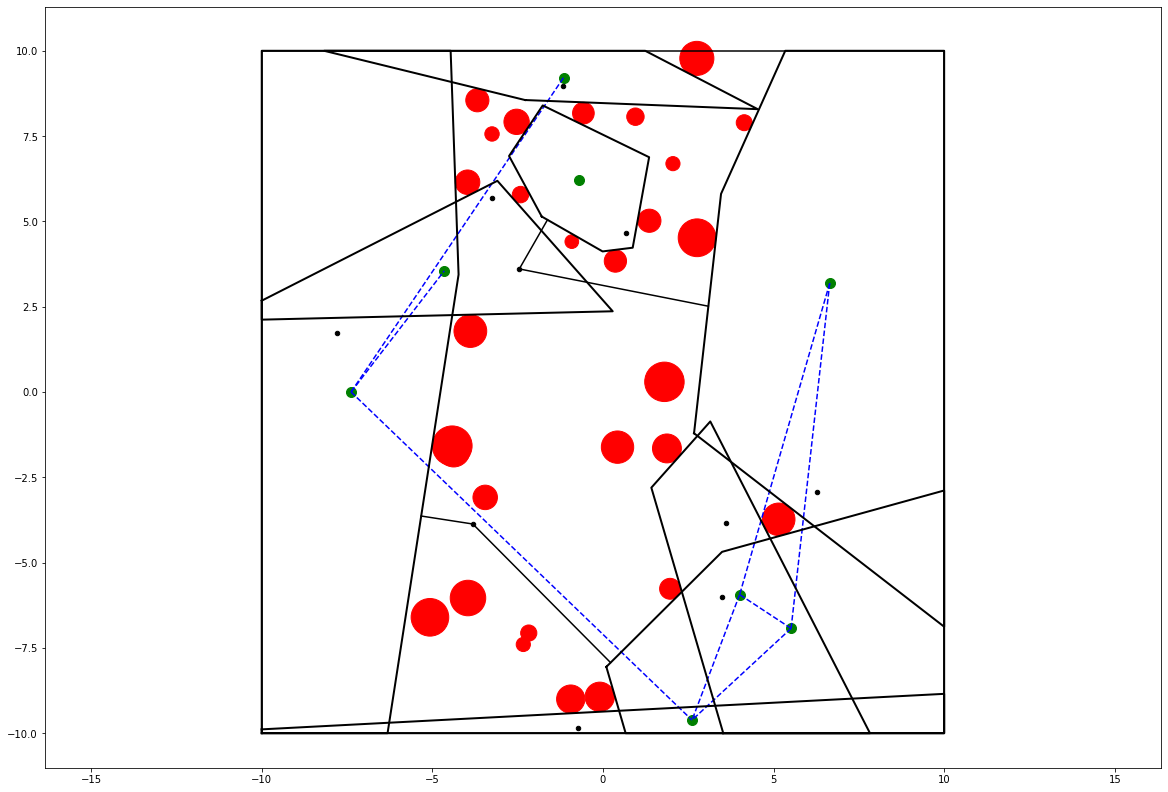

In [77]:
np.random.seed(3)
iris_handle = partial(morph_iris, 
                      obstacles = obstacles, 
                      domain = domain, 
                      options = iris_options)   

set_LOS_check_handle = partial(set_LOS_check, 
                            obstacles = obstacles, 
                            sample_in_set = sample_in_set,
                            margin = 0.5,
                            n_tries = 30,
                            ncollisionchecks = 11, 
                            maxdist = 10.0)

fig, ax = plt.subplots(figsize=(20, 14))
ax.plot([-10, 10, 10, -10, -10], [-10, -10, 10, 10, -10], 'k')
for o in obstacles:
    tree = plt.Circle(o.center(), 1./o.A()[0, 0], color='r')
    ax.add_patch(tree)
ax.axis('equal')

setvprm = SetVPRM2(limits = [lb, ub], 
                    M = 20, 
                    collision_handle = col_handle,
                    is_in_line_of_sight = set_LOS_check_handle,
                    iris_handle = iris_handle,
                    connector_iris_handle = None,
                    plot_node = partial(plot_node, ax = ax),
                    plot_edge = partial(plot_edge, ax = ax),
                    plot_region = partial(plot_region, ax = ax),
                    Verbose = True)

setvprm.build()
#src_pt = np.array([-5, 7.5]).reshape(2,1)
#tree = plt.Circle(src_pt, 0.1, color='b')
#ax.add_patch(tree)
#is_los, pt_in_set = set_LOS_check_handle(src_pt, setvprm.guard_regions[0])

#tree = plt.Circle(pt_in_set, 0.1, color='g')
#ax.add_patch(tree)
#ax.plot([src_pt[0,0], pt_in_set[0,0]], [src_pt[1,0], pt_in_set[1,0]])

In [75]:
setvprm.guards

In [76]:
setvprm.guard_domains

[[<visprm.SetNode at 0x7f9984c0bee0>,

In [103]:
b.count(a)

0

(-11.001049816464443,
 11.000049991260212,
 -11.001099656826488,
 11.001099878462885)

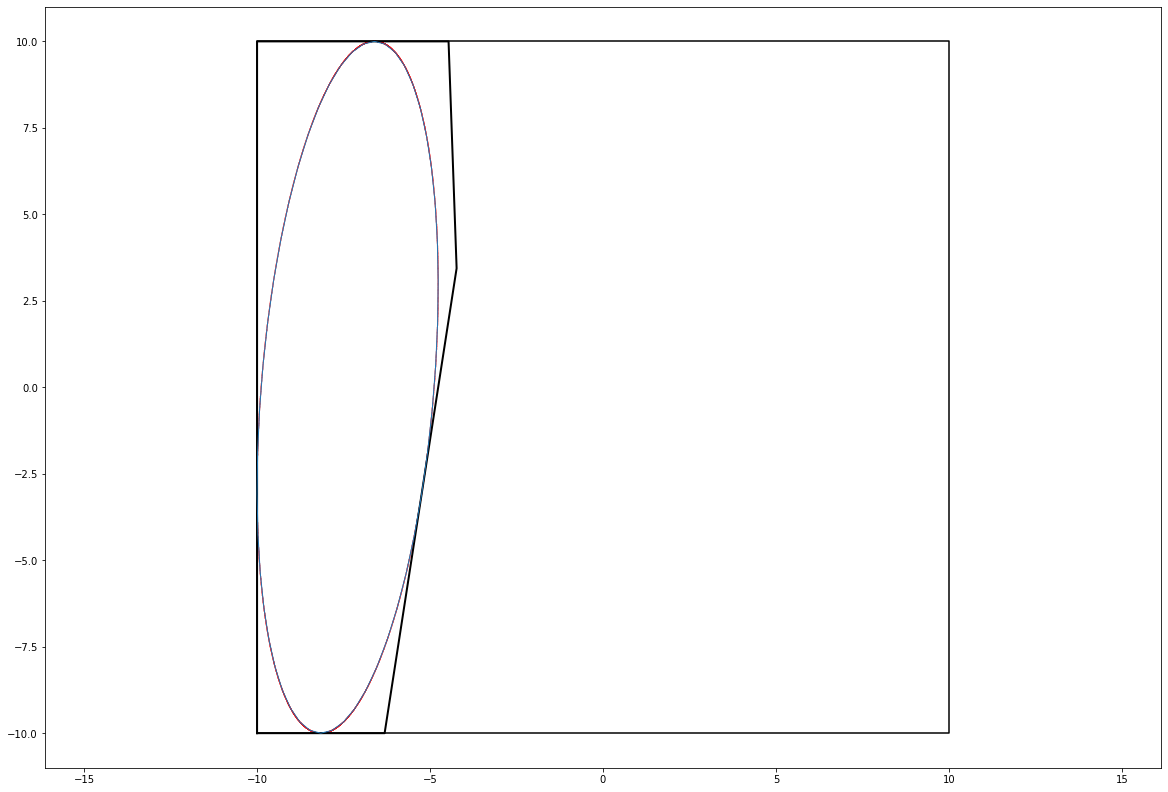

In [74]:
def plot_ellipse(ax, A, center, n_samples):
    angs = np.linspace(0, 2*np.pi, n_samples+1)
    coords = np.zeros((2, n_samples + 1))
    coords[0, :] = np.cos(angs)
    coords[1, :] = np.sin(angs)
    Bu = np.linalg.inv(A)@coords
    pts = Bu + center.reshape(2,1)
    ax.plot(pts[0, :], pts[1, :], linewidth = 1)
    
fig, ax = plt.subplots(figsize=(20, 14))
ax.plot([-10, 10, 10, -10, -10], [-10, -10, 10, 10, -10], 'k')

r = setvprm.guards[0].region
ell= r.MaximumVolumeInscribedEllipsoid()
dim = 2
plot_region(r,ax)
plot_ellipse(ax, ell.A(), ell.center(), 50)

eigs, eigv = np.linalg.eig((ell.A().T@ell.A()))
center = ell.center()
B = np.linalg.inv(ell.A())
Binv = ell.A()

samples = []
for _ in range(10000):
    v = np.random.normal(0, scale = 1, size= dim).reshape(2,1)
    eqval = v.T@(np.diag(eigs))@v
    v_clip = eigv@v/np.sqrt(eqval) +center.reshape(2,1)
    #u_sample = Binv@eigv@v
    #u_norm = np.linalg.norm(u_sample)
    #u_clip = u_sample/u_norm
    #sample = B@u_clip + center.reshape(2,1)
    samples.append(v_clip)
    
for s in samples:
    tree = plt.Circle(s, 0.001, color='r', alpha = 0.1)
    ax.add_patch(tree)
ax.axis('equal')

In [68]:
eqval

array([[5.82949486]])

In [23]:
r = setvprm.guards[0].region
ell= r.MaximumVolumeInscribedEllipsoid()
dim = 2
plot_region(r,ax)
plot_ellipse(ax, ell.A(), ell.center(), 50)

eigs, eigv = np.linalg.eig(ell.A().T@ell.A())
center = ell.center()
B = np.linalg.inv(ell.A())
Binv = ell.A()

samples = []
for _ in range(20000):
    v = np.random.normal(0, scale = 1/np.sqrt(eigs), size= dim).reshape(2,1)
    u_sample = Binv@eigv@v
    u_norm = np.linalg.norm(u_sample)
    u_clip = u_sample/u_norm
    sample = B@u_clip + center.reshape(2,1)
    samples.append(sample)
    
for s in samples:
    tree = plt.Circle(s, 0.03, color='r', alpha = 0.01)
    ax.add_patch(tree)
    
    
class SampleEllipsoid:
    def __init__(self, ell):
        self.ell = ell
        self.eigs, self.eigv = np.linalg.eig(ell.A().T@ell.A())
        self.center = ell.center()
        self.B = np.linalg.inv(ell.A())
        self.Binv = ell.A()
        
    def sample(self,):
        v = np.random.normal(0, scale = 1/np.sqrt(eigs), size= dim).reshape(2,1)
        u_sample = Binv@eigv@v
        u_norm = np.linalg.norm(u_sample)
        u_clip = u_sample/u_norm
        sample = B@u_clip + center.reshape(2,1)
        samples.append(sample)


array([ 2.49294971, 10.03193525])

In [44]:
src_reg = guard_regions[3]
src_pt = np.array([-5,-3.0]).reshape(2,1)
succ, pt = set_LOS_check(src_pt, src_reg, obstacles, sample_in_set)

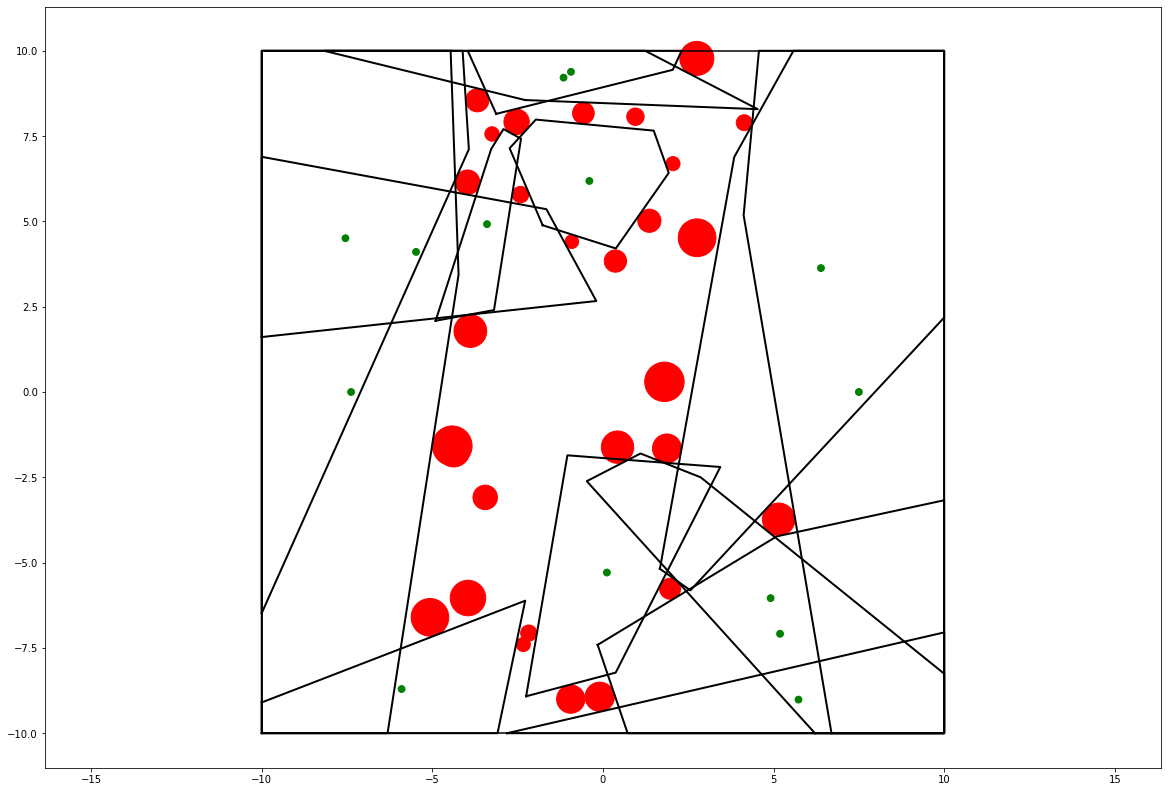

In [74]:
#samps = [sample_in_set(src_ell) for _ in range(20)]

fig, ax = plt.subplots(figsize=(20, 14))
ax.plot([-10, 10, 10, -10, -10], [-10, -10, 10, 10, -10], 'k')

#tree = plt.Circle(src_pt, 0.1, color='b')
#ax.add_patch(tree)

#tree = plt.Circle(pt, 0.1, color='b')
#ax.add_patch(tree)
#ax.plot([src_pt[0,0], p_in_set[0,0]], [src_pt[1,0], p_in_set[1,0]])
for o in obstacles:
    tree = plt.Circle(o.center(), 1./o.A()[0, 0], color='r')
    ax.add_patch(tree)

#for o in samps:
#    tree = plt.Circle(o, 0.01, color='r')
#    ax.add_patch(tree)
ax.axis('equal')
for r in setvprm.guard_regions:
    vert = sorted_vertices(VPolytope(r))
    vert = np.hstack((vert, vert[:, :1]))
    ax.plot(vert[0], vert[1], c = 'k', linewidth = 2)
for r in setvprm.guard_regions:
    c = r.MaximumVolumeInscribedEllipsoid().center()
    tree = plt.Circle(c, 0.1, color='g')
    ax.add_patch(tree)

In [73]:
ell = src_reg.MaximumVolumeInscribedEllipsoid()
ell.A()@samps[0] +ell.center().reshape(2,1)

NameError: name 'src_reg' is not defined

In [173]:
samps

[array([[ 0.3077251 , -3.92816608],
        [ 0.55715731, -3.67873386]]),
 array([[ 0.17891245, -4.05697873],
        [ 0.72197003, -3.51392114]]),
 array([[ 0.34688577, -3.8890054 ],
        [-0.32250896, -4.55840013]]),
 array([[ 0.17025755, -4.06563362],
        [ 0.72736801, -3.50852316]]),
 array([[ 0.05992482, -4.17596636],
        [ 0.72725745, -3.50863372]]),
 array([[-0.02320633, -4.25909751],
        [ 0.20306122, -4.03282995]]),
 array([[ 0.15082616, -4.08506502],
        [ 0.73692255, -3.49896862]]),
 array([[ 0.3202022 , -3.91568897],
        [-0.34080169, -4.57669287]]),
 array([[ 0.16613405, -4.06975712],
        [ 0.72969436, -3.50619682]]),
 array([[ 0.19052373, -4.04536744],
        [-0.30587442, -4.5417656 ]]),
 array([[ 0.41971572, -3.81617546],
        [-0.16233174, -4.39822291]]),
 array([[ 0.14698979, -4.08890138],
        [ 0.73838046, -3.49751071]]),
 array([[ 0.36566118, -3.87023   ],
        [ 0.4160018 , -3.81988937]]),
 array([[ 0.30434392, -3.93154725],
  

1.0